# 7. Analysis of occupational diversity and specialization of labour

*AIM:*

References:

1) `Harris EM. Workshop, Marketplace and Household: The Nature of Technical Specialization in Classical Athens and its Influence on Economy and Society. In: Carledge P, Cohen EE, Foxhall L, editors. Money, Labour and Land: Approaches to the Economy of Ancient Greece. London—New York: Routledge; 2001. pp. 67–99.`
2) `Duranton G, Puga D. Diversity and Specialisation in Cities: Why, Where and When Does it Matter? Urban Stud. 2000;37: 533–555.`




to do:

Petra needs to go through, comment, run, debug


This script was originally published by `Kaše V, Heřmánková P, Sobotková A (2022) Division of labor, specialization and diversity in the ancient Roman cities: A quantitative approach to Latin epigraphy. PLoS ONE 17(6): e0269869. https://doi.org/10.1371/journal.pone.0269869` under a CC BY-SA 4.0 International License. 

https://github.com/sdam-au/social_diversity

The *Past Social Networks Project* adapted the script to fit the needs of the project research agenda.

# Requirements

In [1]:
import json
import pandas as pd
import numpy as np
import geopandas as gpd
from scipy.stats import pearsonr

import nltk

import sddk
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library

# PLOTTING
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:
# but you can have yours stored locally on your computer and read it in directly
s = sddk.cloudSession("sciencedata.dk", ".", "648560@au.dk")
figpath = "./PSNP_shared/lat_socdiv/"

In [4]:
# global parameters for plots
#plt.style.use("seaborn-white")
plt.style.use("seaborn-v0_8-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

def save_figure(fig, fig_name):
    #each figure to be saved in four different versions
    fig.savefig("../../figures/" + fig_name + ".tiff")
    fig.savefig("../../figures/" + fig_name + ".svg")
    fig.savefig("../../figures/" + fig_name + ".png")
    s.write_file(figpath + fig_name + ".eps", fig)
    s.write_file(figpath + fig_name + ".png", fig)

In [5]:
# establish connection with gogglesheets...
file_data = s.read_file("https://sciencedata.dk/files/ServiceAccountsKey.json", "dict") # or load it from a local storage: json.load(open("../../ServiceAccountsKey.json", "r"))
credentials = service_account.Credentials.from_service_account_info(file_data)
gc = gspread.Client(auth=credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']))
socdiv_results = gc.open_by_url("https://docs.google.com/spreadsheets/d/1kACGBS9Xdno7FL2fPZ-vCOu4SSh9uUaZmGvnEghVs_A/edit?usp=sharing")

# Import datasets

In [7]:
LIST = gpd.read_parquet("../../data/large_data/LIST_occupsorgs_industry.parquet")

In [5]:
def proper_nones(type_value):
    if not isinstance(type_value, str):
        type_value = None
    return type_value

LIST["type_of_inscription_auto"] = LIST["type_of_inscription_auto"].apply(proper_nones)

In [8]:
LIST.head(3)

,LIST-ID,EDCS-ID,EDH-ID,trismegistos_uri,pleiades_id,transcription,inscription,clean_text_conservative,clean_text_interpretive_sentence,clean_text_interpretive_word,...,large_city_geo,large_city_dist,medium_city_ID,medium_city_geo,medium_city_dist,small_city_ID,small_city_geo,small_city_dist,urban_context_alt,occups_cats
0,445464,EDCS-24900077,HD056163,https://www.trismegistos.org/text/177366,570485,Q(uinto) Caecilio C(ai) f(ilio) Metelo / imper...,Q(uinto) Caecilio C(ai) f(ilio) Metel(l)o / im...,Q Caecilio C f Metelo imperatori Italici quei ...,Quinto Caecilio Cai filio Metelo imperatori It...,Quinto Caecilio Cai filio Metelo imperatori It...,...,"[22.719769, 37.631278]",10912.81,85,"[22.641069, 37.831664]",26806.86,36,"[23.132244, 37.626573]",25817.21,rural,[]
1,445465,EDCS-03700724,HD052964,https://www.trismegistos.org/text/121715,531064,Fortissimo et piis/simo Caesari d(omino) n(ost...,Fortissimo et Piis/simo Caesari d(omino) n(ost...,Fortissimo et piissimo Caesari d n Gal Val P F...,Fortissimo et piissimo Caesari domino nostro G...,Fortissimo et piissimo Caesari domino nostro G...,...,"[20.733395, 39.026505]",47237.78,7,"[20.987, 39.158]",37687.28,31,"[20.787767, 39.546432]",10725.84,rural,[]
2,445466,EDCS-13800065,HD017714,https://www.trismegistos.org/text/177100,570049,Italicei / quei Aegei negotiantur / P(ublium) ...,Italicei / quei Aegei negotiantur / P(ublium) ...,Italicei quei Aegei negotiantur P Rutilium P f...,Italicei quei Aegei negotiantur Publium Rutili...,Italicei quei Aegei negotiantur Publium Rutili...,...,"[22.726044, 37.9799]",63682.52,24,"[22.044647, 37.885611]",40453.51,6,"[22.081952, 38.252707]",497.57,small,[]


In [9]:
# mask
before235 = LIST["not_before"] < 235
after235 = LIST["not_before"]>=235

In [10]:
len(LIST[before235])

147050

In [11]:
LIST[before235]["occups_N"].sum()

6337

In [12]:
LIST[before235]["occups_N"].sum() / LIST["occups_N"].sum()

0.6121522411128284

In [14]:
roman_cities = gpd.read_parquet("../../data/roman_cities_pop.parquet")
pleiades_regions = gpd.read_file("../../data/pleiades_regions.geojson")
pleiades_regions_west = gpd.read_file("../../data/pleiades_regions_west.geojson")

# Map inscriptions on cities

In [15]:
def get_my_city(row):
    context = row["urban_context_alt"]
    try:
        ID = row[context + "_city_ID"]
    except:
        ID = None
    return ID
    
LIST["city_ID"] = LIST.apply(lambda row: get_my_city(row), axis=1)

In [16]:
def get_inscriptions(ID):
    city_dict = {}
    city_data = LIST[LIST["city_ID"]==str(ID)]
    city_data_post235 = LIST[(LIST["city_ID"]==str(ID)) & (after235)]
    if len(city_data) > 0:
        # all inscriptions
        city_dict["inscr_N"] = len(city_data)
        city_dict["occups_list"] = [el for sublist in city_data["occups"] for el in sublist]
        city_dict["occups_N"] = city_data["occups_N"].sum()
        city_dict["occups_unique_N"] = len(set(city_dict["occups_list"]))
    # inscriptions pre AD235 and post AD235
        city_dict["inscr_N_post235"] = len(city_data_post235)
        city_dict["occups_N_post235"] = city_data_post235["occups_N"].sum()
        city_dict["ratio_post235"] = len(city_data_post235) / len(city_data)
    return city_dict

cities_dict_data = roman_cities["ID"].apply(get_inscriptions)

In [17]:
cities_inscr_data = pd.DataFrame(cities_dict_data.tolist())
cities_inscr_data.head(5)

,inscr_N,occups_list,occups_N,occups_unique_N,inscr_N_post235,occups_N_post235,ratio_post235
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,[],0.0,0.0,0.0,0.0,0.0
3,1.0,[curator],1.0,1.0,0.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
roman_cities = pd.concat([roman_cities, cities_inscr_data], axis=1)

In [19]:
del cities_inscr_data
del cities_dict_data

# Explore inscriptions within cities

In [21]:
roman_cities.head(3)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,pop_est,pop_diff,western_province,inscr_N,occups_list,occups_N,occups_unique_N,inscr_N_post235,occups_N_post235,ratio_post235
0,Hanson2016_1,Abae,Kalapodi,Achaea,Greece,4 or 5,55 D3,-600,NaN,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...,...,1700.0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Hanson2016_2,Acharnae,Acharnes,Achaea,Greece,3,59 B2,-600,NaN,BNP; DGRG; PECS; Sear 2006.,...,1000.0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Hanson2016_3,Acraephia,Akraifnio,Achaea,Greece,3,55 E4,-600,NaN,BNP; DGRG; Hansen and Nielsen 2004; PECS; Sear...,...,1000.0,NaN,False,2.0,[],0.0,0.0,0.0,0.0,0.0


In [22]:
# all cities
len(roman_cities)

1388

In [23]:
roman_cities["pop_est"].sum()

10214337.0

In [24]:
roman_cities["inscr_N"].sum()

369849.0

In [25]:
# cities with at least one inscription
(roman_cities["inscr_N"]>0).sum()

1176

In [26]:
# proportion of cities with at least one inscription
(roman_cities["inscr_N"]>0).mean()

0.8472622478386167

In [27]:
# N western cities
(roman_cities["western_province"]).sum()

889

In [28]:
((roman_cities["western_province"]) & (roman_cities["inscr_N"]>0)).sum()

850

In [29]:
((roman_cities["western_province"]) & (roman_cities["inscr_N"]>0)).sum() / (roman_cities["western_province"]).sum()

0.9561304836895388

In [30]:
LIST["is_western"].sum()

471044

In [31]:
LIST["is_western"].sum() / len(LIST)

0.9200563310955852

# Measuring Specialization and Diversity

In [37]:
len(roman_cities)

889

In [38]:
roman_cities["inscr_N"].sum()

355242.0

In [41]:
(roman_cities["occups_N"]>0).sum()

506

In [42]:
roman_cities[roman_cities["occups_N"]>0]["inscr_N"].sum()

335027.0

In [44]:
roman_cities[roman_cities["occups_N"]>0]["inscr_N"].sum() / len(LIST)

0.6543841179124681

In [45]:
roman_cities[roman_cities["occups_N"]>0]["pop_est"].sum()

4214228.0

In [47]:
3250628.0 / 5368578.0

0.6054914355346984

In [48]:
3250628.0 / 10214337.0

0.3182417028143873

In [49]:
97216 / len(LIST)

0.18988501346750708

# Western cities with inscriptions (roman_cities_wo)

In [50]:
# roman cities western with at least one occupations
roman_cities_wo = roman_cities[roman_cities["occups_N"]>0].copy()

In [52]:
roman_cities_wo["city_province"] = roman_cities_wo.apply(lambda row: row["Ancient Toponym"] + " (" + row["Province"] + ")", axis=1)

In [53]:
roman_cities_wo["occups_N"].sum()

8326.0

In [54]:
roman_cities_wo["occups_N"].sum() / LIST["occups_N"].sum()

0.8042890262751159

In [55]:
LIST["occups_N"].sum()

10352

In [56]:
roman_cities_wo

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,pop_diff,western_province,inscr_N,occups_list,occups_N,occups_unique_N,inscr_N_post235,occups_N_post235,ratio_post235,city_province
156,Hanson2016_157,Abbir Maius,Henchir en Naam,Africa Proconsularis,Tunisia,3,32 F4,100,NaN,BNP; Lepelley 1979-1981.,...,NaN,True,12.0,[curator],1.0,1.0,0.0,0.0,0.000000,Abbir Maius (Africa Proconsularis)
158,Hanson2016_159,Abthungi,Henchir es Souar,Africa Proconsularis,Tunisia,3,32 E4,-50,NaN,Boatwright 2000; Lepelley 1979-1981; Quinn and...,...,NaN,True,36.0,"[curator, curator, curator, curator, curator, ...",6.0,2.0,6.0,4.0,0.166667,Abthungi (Africa Proconsularis)
159,Hanson2016_160,Acholla,Henchir Bou Tria,Africa Proconsularis,Tunisia,4 or 5,33 H2,-200,NaN,BNP; Boatwright 2000; Bomgardner 2000; DGRG; G...,...,NaN,True,17.0,"[curator, curator, curator]",3.0,1.0,1.0,1.0,0.058824,Acholla (Africa Proconsularis)
160,Hanson2016_161,Agbia,Henchir Ain Hedja,Africa Proconsularis,Tunisia,3,32 D4,100,NaN,BNP; Bomgardner 2000; Lepelley 1979-1981; McEv...,...,NaN,True,141.0,"[curator, artifex]",2.0,2.0,7.0,0.0,0.049645,Agbia (Africa Proconsularis)
162,Hanson2016_163,Apisa Maius,Tarf ech Chena,Africa Proconsularis,Tunisia,3,32 E4,200,NaN,BNP; Lepelley 1979-1981.,...,NaN,True,51.0,"[curator, curator, columnarius, curator, curat...",6.0,2.0,0.0,0.0,0.000000,Apisa Maius (Africa Proconsularis)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1311,Hanson2016_1312,Messana,Messina,Sicilia,Italy,3,47 H2,-730,NaN,Brunt 1971; Cornell and Mathews 1982; Hansen 2...,...,NaN,True,164.0,"[medicus, faber, arcarius, scriba]",4.0,4.0,2.0,0.0,0.012195,Messana (Sicilia)
1315,Hanson2016_1316,Panormus,Palermo,Sicilia,Italy,2,47 C2,-700,NaN,Beloch 1886; BNP; Brunt 1971; Cornell and Math...,...,NaN,True,221.0,"[curator, curator, negotians]",3.0,2.0,11.0,1.0,0.049774,Panormus (Sicilia)
1317,Hanson2016_1318,Segesta,Segesta,Sicilia,Italy,3,47 B3,-600,NaN,McEvedy 2011; PECS; Sear 2006; Woloch 1983.,...,NaN,True,113.0,[forensis],1.0,1.0,1.0,0.0,0.008850,Segesta (Sicilia)
1319,Hanson2016_1320,Syracusae,Syracuse,Sicilia,Italy,2,47 G4,-733,NaN,Beloch 1886; Benario 1981; Brunt 1971; Cornell...,...,NaN,True,627.0,"[medicus, fullo, trapezita]",3.0,3.0,14.0,1.0,0.022329,Syracusae (Sicilia)


In [58]:
# generate a dictionary of occupations by type
occupations_df = pd.read_csv("../../data/occupations_list_hisco.csv")

def term1_plus_term2(row):
    term1_2 = row["Term"]
    if isinstance(row["Term2"], str):
        term1_2 += " " + row["Term2"]
    return term1_2

occupations_df["Term"] = occupations_df.apply(lambda row: term1_plus_term2(row), axis=1)

occups_cats_dict = dict(zip(occupations_df["Term"], occupations_df["Harris_Category"]))

In [59]:
print(len(set(occups_cats_dict.values())))
set(occups_cats_dict.values())

19


{'Building',
 'Clothing',
 'Death-care sector',
 'Education',
 'Finance',
 'Food-Production',
 'Food-Retail',
 'Fuel / Raw material',
 'Glass-Working',
 'Household Goods',
 'Managerial',
 'Metal-Working',
 'Miscellaneous Services',
 'Performing Arts',
 'Plastic Arts',
 'Retail',
 'Transport',
 'Unclassified',
 'Water-Management'}

In [60]:
occups_cats_labels = list(set(occups_cats_dict.values()))
occups_cats_labels

['Food-Production',
 'Retail',
 'Metal-Working',
 'Death-care sector',
 'Glass-Working',
 'Household Goods',
 'Transport',
 'Plastic Arts',
 'Education',
 'Fuel / Raw material',
 'Food-Retail',
 'Managerial',
 'Clothing',
 'Water-Management',
 'Performing Arts',
 'Unclassified',
 'Finance',
 'Building',
 'Miscellaneous Services']

In [61]:
def cat_for_occup(list_of_occups):
    try:
        return [occups_cats_dict[occup] for occup in list_of_occups]
    except:
        return []
roman_cities_wo["occups_cats_list"] = roman_cities_wo["occups_list"].apply(cat_for_occup)

In [62]:
LIST["occups_cats_list"] = LIST["occups"].apply(cat_for_occup)

In [63]:
roman_cities_wo[roman_cities_wo["Ancient Toponym"]=="Roma"]["occups_cats_list"]

991    [Unclassified, Managerial, Education, Manageri...
Name: occups_cats_list, dtype: object

In [64]:
roman_cities_wo["occups_cats_unique_N"] = roman_cities_wo["occups_cats_list"].apply(lambda x: len(set(x)))
roman_cities_wo["occups_cats_unique_N"]

156     1
158     2
159     1
160     2
162     2
       ..
1311    4
1315    2
1317    1
1319    3
1321    1
Name: occups_cats_unique_N, Length: 506, dtype: int64

In [65]:
len(roman_cities_wo[roman_cities_wo["occups_N"]==1])

107

In [66]:
85 / 313

0.2715654952076677

Text(0, 0.5, 'N cities')

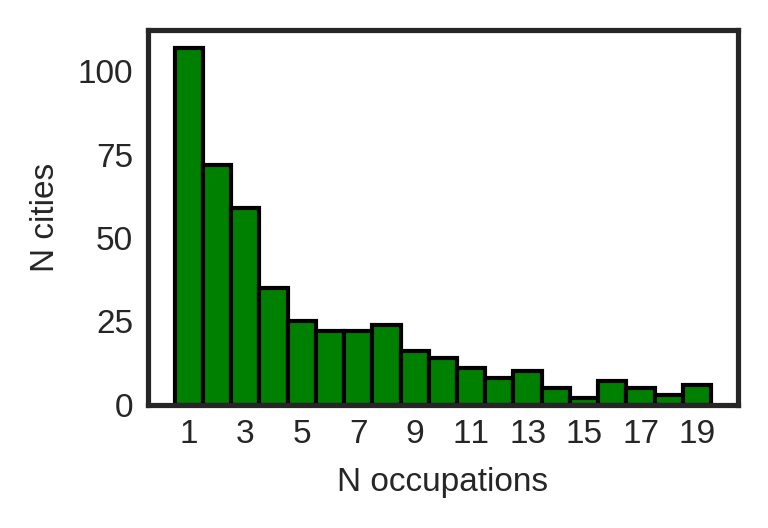

In [67]:
fig, ax = plt.subplots(figsize=(2.6, 1.8), tight_layout=True)
bins = [n+0.5 for n in range(0,20)]
roman_cities_wo["occups_N"].hist(ax=ax, edgecolor="black", color="green", bins=bins)
ax.set_xticks(range(1,20, 2))
ax.grid(False)
ax.set_xlabel("N occupations")
ax.set_ylabel("N cities")

Text(0, 0.5, 'N cities')

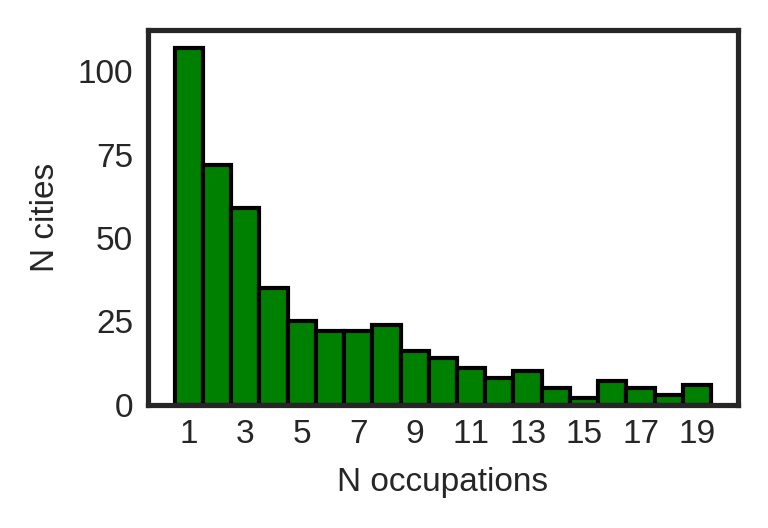

In [68]:
fig, ax = plt.subplots(figsize=(2.6, 1.8), tight_layout=True)
bins = [n+0.5 for n in range(0,20)]
roman_cities_wo["occups_N"].hist(ax=ax, edgecolor="black", color="green", bins=bins)
ax.set_xticks(range(1,20, 2))
ax.grid(False)
ax.set_xlabel("N occupations")
ax.set_ylabel("N cities")

Text(0, 0.5, 'N cities')

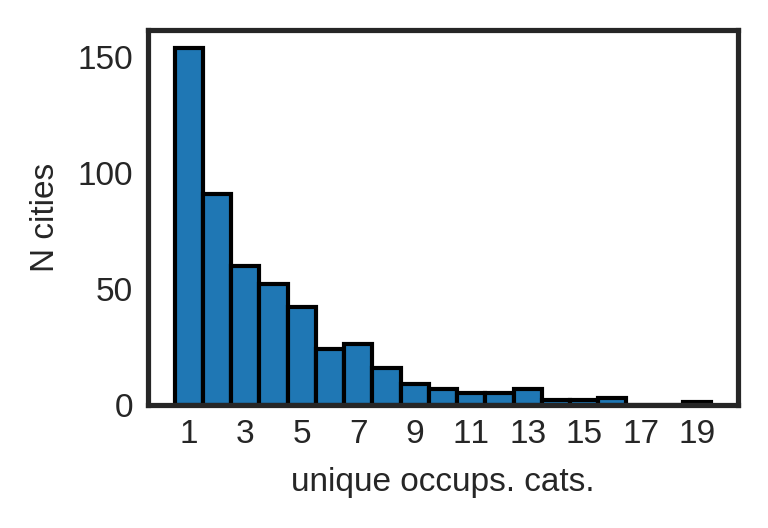

In [69]:
fig, ax = plt.subplots(figsize=(2.6, 1.8), tight_layout=True)
bins = [n+0.5 for n in range(0,20)]
roman_cities_wo["occups_cats_unique_N"].hist(ax=ax, edgecolor="black", bins=bins)
ax.set_xticks(range(1,20, 2))
ax.grid(False)
ax.set_xlabel("unique occups. cats.")
ax.set_ylabel("N cities")

In [70]:
save_figure(fig, "LIST_unique_cats_per_cities_hist")

A file with the same name ("unique_cats_per_cities_hist.eps") already exists in this location.


Press Enter to overwrite it or choose different path and filename:  
Unsupported file format. Type either "txt", "csv", "json", "geojson", "feather", or "png":  


Your <class 'matplotlib.figure.Figure'> object has been succesfully written as "https://sciencedata.dk/sharingout/648597%40au.dk/SDAM_root/SDAM_data/social_diversity/socdiv_figures/unique_cats_per_cities_hist."
A file with the same name ("unique_cats_per_cities_hist.png") already exists in this location.


Press Enter to overwrite it or choose different path and filename:  


Your <class 'matplotlib.figure.Figure'> object has been succesfully written as "https://sciencedata.dk/sharingout/648597%40au.dk/SDAM_root/SDAM_data/social_diversity/socdiv_figures/unique_cats_per_cities_hist.png"


In [71]:
roman_cities_wo["occups_cats_list"]

156                                          [Managerial]
158     [Managerial, Managerial, Managerial, Manageria...
159                  [Managerial, Managerial, Managerial]
160                            [Managerial, Plastic Arts]
162     [Managerial, Managerial, Building, Managerial,...
                              ...                        
1311    [Miscellaneous Services, Unclassified, Finance...
1315                     [Managerial, Managerial, Retail]
1317                                         [Managerial]
1319          [Miscellaneous Services, Clothing, Finance]
1321                             [Managerial, Managerial]
Name: occups_cats_list, Length: 506, dtype: object

# Specialization

In [72]:
def get_cat_row_vec(cat_list):
    cat_row_vec = []
    for cat in occups_cats_labels:
        cat_row_vec.append(cat_list.count(cat))
    return np.array(cat_row_vec)


In [73]:
roman_cities_wo["occups_cats_vec"] = roman_cities_wo["occups_cats_list"].apply(get_cat_row_vec)
roman_cities_wo["occups_cats_vec"]

156     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
158     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 1, ...
159     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, ...
160     [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...
162     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, ...
                              ...                        
1311    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
1315    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, ...
1317    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
1319    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...
1321    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, ...
Name: occups_cats_vec, Length: 506, dtype: object

In [74]:
def occups_cats_vec_weighted(occups_cat_vec):
    a = np.array(occups_cat_vec, dtype=float)
    a = a / sum(a)
    return a
roman_cities_wo["shares_vec"] = roman_cities_wo["occups_cats_vec"].apply(occups_cats_vec_weighted)
roman_cities_wo["shares_vec"]

156     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
158     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
159     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
160     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, ...
162     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
1311    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25,...
1315    [0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, ...
1317    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1319    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1321    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: shares_vec, Length: 506, dtype: object

In [75]:
roman_cities_wo["ZI"] = roman_cities_wo["shares_vec"].apply(max)
roman_cities_wo["ZI"]

156     1.000000
158     0.833333
159     1.000000
160     0.500000
162     0.833333
          ...   
1311    0.250000
1315    0.666667
1317    1.000000
1319    0.333333
1321    1.000000
Name: ZI, Length: 506, dtype: float64

In [77]:
roman_cities_wo["largest_cat"] = roman_cities_wo["occups_cats_vec"].apply(max)

In [78]:
roman_cities_wo

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,inscr_N_post235,occups_N_post235,ratio_post235,city_province,occups_cats_list,occups_cats_unique_N,occups_cats_vec,shares_vec,ZI,largest_cat
156,Hanson2016_157,Abbir Maius,Henchir en Naam,Africa Proconsularis,Tunisia,3,32 F4,100,NaN,BNP; Lepelley 1979-1981.,...,0.0,0.0,0.000000,Abbir Maius (Africa Proconsularis),[Managerial],1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,1
158,Hanson2016_159,Abthungi,Henchir es Souar,Africa Proconsularis,Tunisia,3,32 E4,-50,NaN,Boatwright 2000; Lepelley 1979-1981; Quinn and...,...,6.0,4.0,0.166667,Abthungi (Africa Proconsularis),"[Managerial, Managerial, Managerial, Manageria...",2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.833333,5
159,Hanson2016_160,Acholla,Henchir Bou Tria,Africa Proconsularis,Tunisia,4 or 5,33 H2,-200,NaN,BNP; Boatwright 2000; Bomgardner 2000; DGRG; G...,...,1.0,1.0,0.058824,Acholla (Africa Proconsularis),"[Managerial, Managerial, Managerial]",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,3
160,Hanson2016_161,Agbia,Henchir Ain Hedja,Africa Proconsularis,Tunisia,3,32 D4,100,NaN,BNP; Bomgardner 2000; Lepelley 1979-1981; McEv...,...,7.0,0.0,0.049645,Agbia (Africa Proconsularis),"[Managerial, Plastic Arts]",2,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, ...",0.500000,1
162,Hanson2016_163,Apisa Maius,Tarf ech Chena,Africa Proconsularis,Tunisia,3,32 E4,200,NaN,BNP; Lepelley 1979-1981.,...,0.0,0.0,0.000000,Apisa Maius (Africa Proconsularis),"[Managerial, Managerial, Building, Managerial,...",2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.833333,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1311,Hanson2016_1312,Messana,Messina,Sicilia,Italy,3,47 H2,-730,NaN,Brunt 1971; Cornell and Mathews 1982; Hansen 2...,...,2.0,0.0,0.012195,Messana (Sicilia),"[Miscellaneous Services, Unclassified, Finance...",4,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25,...",0.250000,1
1315,Hanson2016_1316,Panormus,Palermo,Sicilia,Italy,2,47 C2,-700,NaN,Beloch 1886; BNP; Brunt 1971; Cornell and Math...,...,11.0,1.0,0.049774,Panormus (Sicilia),"[Managerial, Managerial, Retail]",2,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, ...","[0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, ...",0.666667,2
1317,Hanson2016_1318,Segesta,Segesta,Sicilia,Italy,3,47 B3,-600,NaN,McEvedy 2011; PECS; Sear 2006; Woloch 1983.,...,1.0,0.0,0.008850,Segesta (Sicilia),[Managerial],1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,1
1319,Hanson2016_1320,Syracusae,Syracuse,Sicilia,Italy,2,47 G4,-733,NaN,Beloch 1886; Benario 1981; Brunt 1971; Cornell...,...,14.0,1.0,0.022329,Syracusae (Sicilia),"[Miscellaneous Services, Clothing, Finance]",3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.333333,1


In [79]:
roman_cities_wo["ZI_cat"] = roman_cities_wo["shares_vec"].apply(lambda x: occups_cats_labels[np.argmax(x)])

In [80]:
roman_cities_wo.sort_values("ZI", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_cats_unique_N","occups_cats_vec", "ZI", "ZI_cat"]]

,Ancient Toponym,inscr_N,occups_N,occups_cats_unique_N,occups_cats_vec,ZI,ZI_cat
156,Abbir Maius,12.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1.000000,Managerial
682,Aquae Flaviae,117.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",1.000000,Performing Arts
685,Baetulo,51.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1.000000,Managerial
686,Barcino,138.0,2.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, ...",1.000000,Managerial
690,Caesaraugusta,57.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1.000000,Managerial
...,...,...,...,...,...,...,...
1271,Mursa,191.0,6.0,6,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...",0.166667,Food-Production
620,Lutetia,584.0,6.0,6,"[0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.166667,Retail
226,Cemelenum,354.0,12.0,7,"[0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, ...",0.166667,Transport
1064,Verona,1284.0,43.0,13,"[1, 4, 6, 0, 0, 1, 1, 3, 0, 0, 0, 7, 7, 0, 1, ...",0.162791,Managerial


In [81]:
roman_cities_wo["ZIw"] = roman_cities_wo.apply(lambda row: row["ZI"] * row["occups_N_log"], axis=1)
roman_cities_wo.sort_values("ZIw", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_list","occups_cats_unique_N", "occups_cats_vec", "ZI", "ZIw", "ZI_cat"]]

KeyError: 'occups_N_log'

In [82]:
roman_cities_wo["ZIw"] = roman_cities_wo.apply(lambda row: row["ZI"] * row["occups_N_log"], axis=1)
roman_cities_wo.sort_values("ZIw", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_list","occups_cats_unique_N", "occups_cats_vec", "ZI", "ZIw", "ZI_cat"]]

KeyError: 'occups_N_log'

In [83]:
# Total shares
all_occups_N = roman_cities_wo["occups_N"].sum()
index_label_sum_dict = {}
for i, cat in zip(range(len(occups_cats_labels)), occups_cats_labels):
    cat_sum = sum(roman_cities_wo["occups_cats_vec"].apply(lambda vec: vec[i]))
    cat_share = cat_sum / all_occups_N
    index_label_sum_dict[i] = [cat, cat_sum, cat_share]
index_label_sum_dict

{0: ['Food-Production', 467, 0.05608935863559933],
 1: ['Retail', 675, 0.08107134278164785],
 2: ['Metal-Working', 796, 0.09560413163583954],
 3: ['Death-care sector', 7, 0.0008407398510689407],
 4: ['Glass-Working', 23, 0.0027624309392265192],
 5: ['Household Goods', 167, 0.020057650732644726],
 6: ['Transport', 309, 0.03711265914004324],
 7: ['Plastic Arts', 129, 0.015493634398270478],
 8: ['Education', 402, 0.04828248858995916],
 9: ['Fuel / Raw material', 9, 0.001080951237088638],
 10: ['Food-Retail', 88, 0.010569300984866683],
 11: ['Managerial', 1747, 0.2098246456882056],
 12: ['Clothing', 507, 0.060893586355993276],
 13: ['Water-Management', 33, 0.003963487869325006],
 14: ['Performing Arts', 377, 0.045279846264712945],
 15: ['Unclassified', 693, 0.08323324525582512],
 16: ['Finance', 167, 0.020057650732644726],
 17: ['Building', 623, 0.07482584674513572],
 18: ['Miscellaneous Services', 1107, 0.13295700216190248]}

In [84]:
total_shares = np.array([val[2] for val in index_label_sum_dict.values()])
total_shares

array([0.05608936, 0.08107134, 0.09560413, 0.00084074, 0.00276243,
       0.02005765, 0.03711266, 0.01549363, 0.04828249, 0.00108095,
       0.0105693 , 0.20982465, 0.06089359, 0.00396349, 0.04527985,
       0.08323325, 0.02005765, 0.07482585, 0.132957  ])

In [85]:
def get_shares_weighted(vec):
    a = np.array(vec, dtype=float)
    b = total_shares
    shares_weighted =  np.divide(a, b, out=np.zeros_like(a), where=b!=0)
    return shares_weighted

roman_cities_wo["shares_weighted_vec"] = roman_cities_wo["shares_vec"].apply(lambda vec: get_shares_weighted(vec))
roman_cities_wo["shares_weighted_vec"]

156     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
158     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
159     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
160     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.2713178...
162     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
1311    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.177...
1315    [0.0, 4.111604938271605, 0.0, 0.0, 0.0, 0.0, 0...
1317    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1319    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1321    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: shares_weighted_vec, Length: 506, dtype: object

In [87]:
roman_cities_wo["RZI"] = roman_cities_wo["shares_weighted_vec"].apply(max)
roman_cities_wo["RZI"]

156      4.765884
158      3.971570
159      4.765884
160     32.271318
162      3.971570
          ...    
1311    12.464072
1315     4.111605
1317     4.765884
1319    16.618762
1321     4.765884
Name: RZI, Length: 506, dtype: float64

In [88]:
roman_cities_wo["RZI_cat"] = roman_cities_wo["shares_weighted_vec"].apply(lambda x: index_label_sum_dict[np.argmax(x)][0])
roman_cities_wo["RZI_cat"]

156       Managerial
158       Managerial
159       Managerial
160     Plastic Arts
162       Managerial
            ...     
1311         Finance
1315          Retail
1317      Managerial
1319         Finance
1321      Managerial
Name: RZI_cat, Length: 506, dtype: object

In [89]:
roman_cities_wo["RZIw"] = roman_cities_wo.apply(lambda row: row["RZI"] * row["occups_N_log"], axis=1)
roman_cities_wo.sort_values("RZIw", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_cats_unique_N", "occups_cats_vec", "ZI", "ZIw", "RZI_cat", "RZI", "RZIw"]]

KeyError: 'occups_N_log'

# Diversity

In [90]:
# again, the starting point are the shares:
roman_cities_wo["shares_vec"]

156     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
158     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
159     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
160     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, ...
162     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
1311    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25,...
1315    [0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, ...
1317    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1319    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1321    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: shares_vec, Length: 506, dtype: object

In [91]:
def get_di(shares_vec):
    a = np.array(shares_vec)
    a = a**2
    hh = sum(a) # Hirschman-Herfindahl index
    ihh = 1 / hh # inverse Hirschman-Herfindahl index
    return ihh
roman_cities_wo["DI"] = roman_cities_wo["shares_vec"].apply(get_di)

In [93]:
roman_cities_wo.sort_values("DI", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_cats_unique_N", "occups_cats_vec", "DI"]]

,Ancient Toponym,inscr_N,occups_N,occups_cats_unique_N,occups_cats_vec,DI
991,Roma,120768.0,3097.0,19,"[268, 301, 346, 2, 11, 77, 41, 62, 203, 3, 43,...",9.412875
757,Capua,1304.0,67.0,13,"[5, 7, 9, 0, 0, 1, 2, 0, 2, 0, 1, 12, 5, 0, 0,...",9.332640
650,Narbo Martius,2315.0,103.0,13,"[8, 11, 14, 0, 0, 5, 9, 2, 0, 0, 0, 4, 13, 0, ...",9.217202
883,Corfinium,445.0,16.0,11,"[1, 0, 2, 0, 0, 1, 1, 0, 0, 0, 1, 3, 0, 1, 1, ...",9.142857
986,Pisae,177.0,16.0,11,"[0, 1, 1, 0, 0, 0, 3, 0, 1, 0, 1, 2, 1, 0, 1, ...",9.142857
...,...,...,...,...,...,...
690,Caesaraugusta,57.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1.000000
707,Ilici,210.0,2.0,1,"[0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000
732,Toletum,76.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1.000000
734,Uxama,53.0,1.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",1.000000


In [94]:
def get_diw(a,b):
    if b==0:
        return 0
    else:
        return a / b
roman_cities_wo["DIw"] = roman_cities_wo.apply(lambda row: get_diw(row["DI"], row['occups_N_log']), axis=1)
roman_cities_wo.sort_values("DIw", ascending=False)[["Ancient Toponym", "inscr_N", "occups_N", "occups_list", "occups_cats_unique_N", "DI", "DIw"]]

KeyError: 'occups_N_log'

# Overview tables

### Trier

In [97]:
roman_cities_wo[roman_cities_wo["Modern Toponym"]=="Trier"]

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,occups_cats_unique_N,occups_cats_vec,shares_vec,ZI,largest_cat,ZI_cat,shares_weighted_vec,RZI,RZI_cat,DI
586,Hanson2016_587,Colonia Augusta Treverorum,Trier,Gallia Belgica,Germany,2,11 G3,-27,NaN,Bedon 2001; Bedon et al 1988; Benario 1981; Go...,...,11,"[4, 9, 4, 0, 3, 1, 1, 4, 0, 0, 0, 0, 0, 0, 1, ...","[0.125, 0.28125, 0.125, 0.0, 0.09375, 0.03125,...",0.28125,9,Retail,"[2.2285867237687365, 3.4691666666666667, 1.307...",33.9375,Glass-Working,6.736842


In [98]:
roman_cities_wo.sort_values("ratio_post235", ascending=False).head(20)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,occups_cats_unique_N,occups_cats_vec,shares_vec,ZI,largest_cat,ZI_cat,shares_weighted_vec,RZI,RZI_cat,DI
784,Hanson2016_785,Nola,Nola,Italia (I Latium and Campania),Italy,2,44 G4,-600,NaN,Beloch 1880; Bispham 2007; Cornell and Mathews...,...,5,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 5, 1, 0, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.083...",0.416667,5,Managerial,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.725...",4.004810,Unclassified,3.272727
367,Hanson2016_368,Ucubi,Espejo,Baetica,Spain,3,27 A4,-49,NaN,Brunt 1971; Cornell and Mathews 1982; DGRG; Ke...,...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,1,Managerial,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.765884,Managerial,1.000000
1026,Hanson2016_1027,Albingaunum,Albenga,Italia (IX Liguria),Italy,3,16 F1,-89,NaN,Beloch 1880; BNP; de Ligt 2012; DGRG; Golvin 1...,...,2,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, ...","[0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.750000,3,Managerial,"[4.457173447537473, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",4.457173,Food-Production,1.600000
1031,Hanson2016_1032,Dertona,Tortona,Italia (IX Liguria),Italy,3,39 D4,-123,NaN,Beloch 1880; BNP; Cornell and Mathews 1982; de...,...,7,"[1, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, ...","[0.07692307692307693, 0.23076923076923078, 0.0...",0.307692,4,Unclassified,"[1.371437983857684, 2.8464957264957267, 0.8045...",3.696748,Unclassified,5.121212
991,Hanson2016_992,Roma,Rome,Italia (VII Etruria),Italy,1,43 B2,-700,NaN,Beloch 1886; Benario 1981; de Ligt 2012; Golvi...,...,19,"[268, 301, 346, 2, 11, 77, 41, 62, 203, 3, 43,...","[0.08653535679690022, 0.09719082983532451, 0.1...",0.174362,540,Miscellaneous Services,"[1.5428123783533003, 1.1988308877169065, 1.168...",1.873739,Water-Management,9.412875
732,Hanson2016_733,Toletum,Toledo,Hispania Tarraconensis,Spain,3,27 A2,-50,NaN,BNP; Carreras Monfort 1995-1996; DGRG; Nelis-C...,...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,1,Managerial,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.765884,Managerial,1.000000
192,Hanson2016_193,Pupput,Henchir Souk el Abiod,Africa Proconsularis,Tunisia,3,32 G4,100,NaN,BNP; Bomgardner 2000; DGRG; Lepelley 1979-1981...,...,3,"[0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, ...","[0.0, 0.2222222222222222, 0.2222222222222222, ...",0.555556,5,Managerial,"[0.0, 2.7410699588477367, 2.324399776661083, 0...",2.741070,Retail,2.454545
1274,Hanson2016_1275,Aquae Balissae,Daruvar,Pannonia Superior,Croatia,3,20 E4,100,NaN,BNP; DGRG; PECS; Wilkes 2003b.,...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",1.000000,1,Education,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.71...",20.711443,Education,1.000000
649,Hanson2016_650,Mauves,Mauves,Gallia Narbonensis,France,4 or 5,14 D1,-27,NaN,PECS; Sear 2006.,...,3,"[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.0, ...",0.333333,1,Metal-Working,"[0.0, 0.0, 3.4865996649916244, 0.0, 0.0, 0.0, ...",8.981661,Transport,3.000000
193,Hanson2016_194,Sabratha,Sabrata,Africa Proconsularis,Libya,2,35 E2,-200,NaN,BNP; Bomgardner 2000; Lepelley 1979-1981; PECS...,...,4,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 4, 0, 0, 1, ...","[0.0, 0.0, 0.14285714285714285, 0.0, 0.0, 0.0,...",0.571429,4,Managerial,"[0.0, 0.0, 1.4942569992821249, 0.0, 0.0, 0.0, ...",3.154983,Performing Arts,2.578947


In [99]:
LIST_sel_cols = ["EDCS-ID", "EDH-ID", "type_of_inscription_auto", "not_before", "not_after", "clean_text_interpretive_word", "occups", "occups_N", "occups_cats_list"]

trier_occups = LIST[(LIST["city_ID"]=="587") & (LIST["occups_N"]>0)][LIST_sel_cols]
trier_occups

,EDCS-ID,EDH-ID,type_of_inscription_auto,not_before,not_after,clean_text_interpretive_word,occups,occups_N,occups_cats_list
12131,EDCS-16000492,HD027088,None,151.0,300.0,Deae Minervae Restitutus Gati filius Suessio a...,[aerarius],1,[Metal-Working]
12175,EDCS-11801053,HD049050,epitaph,171.0,230.0,Fortunato negotiatori artis cervesariae ONT MN,[negotiator],1,[Retail]
12177,EDCS-20500303,HD047724,epitaph,NaN,NaN,Dis Manibus SPER IIIIII vir negotiator CISAR,[negotiator],1,[Retail]
12219,EDCS-10600409,HD076371,votive inscription,151.0,300.0,In honorem domus divinae Genio arenariorum con...,[arenarius],1,[Performing Arts]
12244,EDCS-10600434,HD076429,votive inscription,1.0,300.0,In honorem domus divinae Moderatius Modestus u...,[negotiator],1,[Retail]
12270,EDCS-10600461,HD078352,epitaph,1.0,300.0,Iustio Muciano decurioni civitatis Treverorum ...,[aerarius],1,[Metal-Working]
12278,EDCS-10600469,HD078368,epitaph,101.0,300.0,Dis Manibus Eugeniae filiae defunctae Iulius V...,"[saccarius, cuparius]",2,"[Transport, Metal-Working]"
12279,EDCS-10600470,HD078370,epitaph,101.0,300.0,Dis Manibus Secundiniae Tavenae coniugi defunc...,[faber],1,[Unclassified]
12281,EDCS-10600472,HD078372,epitaph,1.0,300.0,coniugi negotiatori artis R sibi viva fecit,[negotiator],1,[Retail]
12282,EDCS-10600473,HD077341,epitaph,351.0,400.0,Silvanus negotiator hic pausat in pace,[negotiator],1,[Retail]


In [103]:
set_with_dataframe(socdiv_results.add_worksheet("trier_20231120", 1,1), trier_occups)
trier_occups.to_csv("../../data/LIST_occupational_inscriptions_trier.csv", index=False)

In [104]:
all_measures = [["ZIw", "ZI_cat"], ["RZIw", "RZI_cat"], ["DI"], ["DIw"]]
sel_cols = ["Ancient Toponym", "Country", "pop_est", "inscr_N", "occups_N", "largest_cat", "occups_cats_unique_N"]

In [105]:
roman_cities_wo

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,occups_cats_unique_N,occups_cats_vec,shares_vec,ZI,largest_cat,ZI_cat,shares_weighted_vec,RZI,RZI_cat,DI
156,Hanson2016_157,Abbir Maius,Henchir en Naam,Africa Proconsularis,Tunisia,3,32 F4,100,NaN,BNP; Lepelley 1979-1981.,...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,1,Managerial,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.765884,Managerial,1.000000
158,Hanson2016_159,Abthungi,Henchir es Souar,Africa Proconsularis,Tunisia,3,32 E4,-50,NaN,Boatwright 2000; Lepelley 1979-1981; Quinn and...,...,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.833333,5,Managerial,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.971570,Managerial,1.384615
159,Hanson2016_160,Acholla,Henchir Bou Tria,Africa Proconsularis,Tunisia,4 or 5,33 H2,-200,NaN,BNP; Boatwright 2000; Bomgardner 2000; DGRG; G...,...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,3,Managerial,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.765884,Managerial,1.000000
160,Hanson2016_161,Agbia,Henchir Ain Hedja,Africa Proconsularis,Tunisia,3,32 D4,100,NaN,BNP; Bomgardner 2000; Lepelley 1979-1981; McEv...,...,2,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, ...",0.500000,1,Plastic Arts,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.2713178...",32.271318,Plastic Arts,2.000000
162,Hanson2016_163,Apisa Maius,Tarf ech Chena,Africa Proconsularis,Tunisia,3,32 E4,200,NaN,BNP; Lepelley 1979-1981.,...,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.833333,5,Managerial,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.971570,Managerial,1.384615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1311,Hanson2016_1312,Messana,Messina,Sicilia,Italy,3,47 H2,-730,NaN,Brunt 1971; Cornell and Mathews 1982; Hansen 2...,...,4,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25,...",0.250000,1,Education,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.177...",12.464072,Finance,4.000000
1315,Hanson2016_1316,Panormus,Palermo,Sicilia,Italy,2,47 C2,-700,NaN,Beloch 1886; BNP; Brunt 1971; Cornell and Math...,...,2,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, ...","[0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, ...",0.666667,2,Managerial,"[0.0, 4.111604938271605, 0.0, 0.0, 0.0, 0.0, 0...",4.111605,Retail,1.800000
1317,Hanson2016_1318,Segesta,Segesta,Sicilia,Italy,3,47 B3,-600,NaN,McEvedy 2011; PECS; Sear 2006; Woloch 1983.,...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.000000,1,Managerial,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.765884,Managerial,1.000000
1319,Hanson2016_1320,Syracusae,Syracuse,Sicilia,Italy,2,47 G4,-733,NaN,Beloch 1886; Benario 1981; Brunt 1971; Cornell...,...,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.333333,1,Clothing,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16.618762,Finance,3.000000


In [106]:
cols_renaming = {"Ancient Toponym" : "city",
                 "Country" : "country",
                 "pop_est" : "pop. est.",
                 "inscr_N" : "N inscriptions",
                 "occups_N" : "N occupations",
                 "occups_cats_unique_N": "N sectors",
                 "ZI_cat" : "largest sector",
                 "RZI_cat" : "largest sector",
                 "largest_cat" : "N occ. in largest sector"
                 }

In [107]:
def get_sorted_table(df, sel_cols, measures):
    df = df[sel_cols + measures]
    df_sorted = df.sort_values(measures[0], ascending=False)
    for col in ["inscr_N", "pop_est", "occups_N", "occups_cats_unique_N"]:
        df_sorted[col] = df_sorted[col].astype(int)
    for val_col in ["ZIw", "RZIw", "DI", "DIw"]:
        try:
            df_sorted[val_col] = df_sorted[val_col].round(2)
        except:
            pass
    df_sorted = df_sorted.rename(columns=cols_renaming)
    return df_sorted.head(10) # .append(df_sorted.tail(3))

In [109]:
sorted_dfs = {}
for measure_cols in all_measures:
    sorted_dfs["sorted_by_" + measure_cols[0]] = get_sorted_table(roman_cities_wo, sel_cols, measure_cols)

KeyError: "['ZIw'] not in index"

In [110]:
sorted_dfs["sorted_by_ZIw"]

KeyError: 'sorted_by_ZIw'

In [ ]:
# export to gsheets
set_with_dataframe(socdiv_results.add_worksheet("sorted_by_ZIw_10_jan31", 1,1), sorted_dfs["sorted_by_ZIw"])

In [ ]:
# save to csv
sorted_dfs["sorted_by_ZIw"].to_csv("../../data/sorted_by_ZIw_10.csv", index=None)

In [ ]:
### latex version...

In [ ]:
LIST_sel_cols = ["EDCS-ID", "EDH-ID", "type_of_inscription_auto", "not_before", "not_after", "clean_text_interpretive_word", "occups", "occups_N", "occups_cats_list"]

### Carmo

In [ ]:
roman_cities_wo[roman_cities_wo["Ancient Toponym"]=="Carmo"]

In [ ]:
carmo_occups = LIST[(LIST["city_ID"]=="333") & (LIST["occups_N"]>0)][LIST_sel_cols][LIST_sel_cols]
carmo_occups

In [ ]:
set_with_dataframe(socdiv_results.add_worksheet("carmo_feb1", 1,1), carmo_occups)

In [ ]:
carmo_occups.to_csv("../../data/occupational_inscriptions_carmo.csv", index=False)

In [ ]:
roman_cities_wo[roman_cities_wo["Ancient Toponym"]=="Augusta Vindelicum"]

### Augusta vindelicum

In [ ]:
augusta_vindelica_occups = LIST[(LIST["city_ID"]=="1288") & (LIST["occups_N"]>0)][LIST_sel_cols]
augusta_vindelica_occups

In [ ]:
set_with_dataframe(socdiv_results.add_worksheet("augusta_vindelicum_feb1", 1, 1), augusta_vindelica_occups)

In [ ]:
augusta_vindelica_occups.to_csv("../../data/occupational_inscriptions_augista_vindelicum.csv", index=False)

In [ ]:
# Augusta Vindelicum ZIw score before correction
9/10 * np.log(10)

In [ ]:
# Augusta Vindelicum ZIw score after correction
(8/9) * np.log(9)

### Tibur

In [ ]:
##
roman_cities_wo[roman_cities_wo["Ancient Toponym"]=="Tibur"]


In [ ]:
tibur_occups = LIST[(LIST["city_ID"]=="902") & (LIST["occups_N"]>0)][LIST_sel_cols]
tibur_occups

In [ ]:
set_with_dataframe(socdiv_results.add_worksheet("tibur_feb1", 1,1), tibur_occups)

In [ ]:
tibur_occups.to_csv("../../data/occupational_inscriptions_tibur.csv", index=False)

### RZIw

In [ ]:
sorted_dfs["sorted_by_RZIw"]

In [ ]:
sorted_dfs["sorted_by_RZIw"].to_csv("../../data/sorted_by_RZIw_10.csv", index=None)

### DI

In [ ]:
sorted_dfs["sorted_by_DI"]

In [ ]:
### latex version...

In [ ]:
# export to gsheets
#set_with_dataframe(socdiv_results.add_worksheet("sorted_by_DI_10_jan31", 1,1), sorted_dfs["sorted_by_DI"])

In [ ]:
sorted_dfs["sorted_by_DI"].to_csv("../../data/sorted_by_DI_10.csv", index=None)

### Capua

In [ ]:
roman_cities_wo[roman_cities_wo["Ancient Toponym"]=="Capua"]

In [ ]:
capua_occups = LIST[(LIST["city_ID"]=="758") & (LIST["occups_N"]>0)][LIST_sel_cols]
capua_occups

In [ ]:
set_with_dataframe(socdiv_results.add_worksheet("capua_feb1", 1,1), capua_occups)

In [ ]:
capua_occups.to_csv("../../data/occupational_inscriptions_capua.csv", index=False)

### Pisae

In [ ]:
roman_cities_wo[roman_cities_wo["Ancient Toponym"]=="Pisae"]

In [ ]:
pisae_occups = LIST[(LIST["city_ID"]=="987") & (LIST["occups_N"]>0)][LIST_sel_cols]
pisae_occups

In [ ]:
set_with_dataframe(socdiv_results.add_worksheet("pisae_feb1", 1,1), pisae_occups)
pisae_occups.to_csv("../../data/occupational_inscriptions_pisae.csv", index=False)

### DIw

In [ ]:
sorted_dfs["sorted_by_DIw"]

In [ ]:
sorted_dfs["sorted_by_DIw"].to_csv("../../data/sorted_by_DIw_10.csv", index=False)

In [ ]:
def get_dzi(row):
    try:
        dzi = row["DI"] / row["ZIw"]
    except:
        dzi = 0
    return dzi


roman_cities_wo["DI/ZIw"] = roman_cities_wo.apply(lambda row: get_dzi(row), axis=1)

In [ ]:
roman_cities_wo.head(5)

# Hanson 2017

In [111]:
# Hanson et al. 2017 on associations
hanson_assoc = pd.read_excel("../../data/hanson2017_supplementary.xlsx")
hanson_assoc.head(10)

FileNotFoundError: [Errno 2] No such file or directory: '../../data/hanson2017_supplementary.xlsx'

In [ ]:
hanson_assoc.drop(["Province"], axis=1, inplace=True)

hanson_assoc["Primary key"] = hanson_assoc["Primary key"].apply(str)

roman_cities_wo["Primary key"] = roman_cities_wo["Primary Key"].apply(lambda x: x.rpartition("_")[2])

In [ ]:
roman_cities_wo

In [ ]:
roman_cities_wo = roman_cities_wo.merge(hanson_assoc, on="Primary key", how="left")
roman_cities_wo

# Export whole dataset

In [112]:
roman_cities_wo.to_parquet("../../data/roman_cities_wo.parquet")
roman_cities_wo.to_csv("../../data/roman_cities_wo.csv")
#set_with_dataframe(socdiv_results.add_worksheet("roman_cities_wo_full_feb2", 1,1), roman_cities_wo)

# Correlation matrix

In [113]:
selected_cols = ["ID", "Ancient Toponym", "pop_est", "Structure", "inscr_N", "occups_N", "occups_list", "occups_unique_N", "occups_cats_unique_N", "largest_cat", "ZIw", "ZI_cat", "RZIw", "RZI_cat", "DI", "DIw", "DI/ZIw"]
#set_with_dataframe(socdiv_results.add_worksheet("roman_cities_wo_sel_20211227", 1,1), roman_cities_wo[selected_cols])

In [114]:
roman_cities_wo_quant = roman_cities_wo[
    (roman_cities_wo["Ancient Toponym"]!="Roma")
    & (roman_cities_wo["occups_N"]>=2)][[
   'Area', 'num_of_structures','pop_est', 'pop_est_log', 'inscr_N',  'inscr_N_log', 'occups_N', 'occups_N_log', 'ZIw', "RZIw",'DI',"DIw", "DI/ZIw", "ratio_post235"]]

KeyError: "['pop_est_log', 'inscr_N_log', 'occups_N_log', 'ZIw', 'RZIw', 'DIw', 'DI/ZIw'] not in index"

In [ ]:
len(roman_cities_wo_quant)

In [ ]:
corr_matrix = roman_cities_wo_quant.corr()
corr_matrix = corr_matrix.round(2)
corr_matrix

In [ ]:
col_labels = ["city area", "structures N", "pop.", "log(pop.)", "inscr. N", "log(inscr. N)", "occups. N", "log(occups. N)", "ZIw", "RZIw", "DI", "DIw", "DI/ZIw", "post 235 CE"]
fig,ax=plt.subplots(figsize=(5.2,3.2), tight_layout=True)
sns.heatmap(corr_matrix, xticklabels=col_labels, yticklabels=col_labels, ax=ax,  cmap="RdYlGn", vmin=-1, vmax=1, annot=True)

In [ ]:
save_figure(fig, "DI_ZI_corr_matrix")

In [ ]:
def get_pvalue_matrix(df):
    df = df.dropna()._get_numeric_data()
    listlist_pvalues = []
    for r in df.columns:
        row_pvalues = []
        for c in df.columns:
            try:
                row_pvalues.append(round(pearsonr(df[r], df[c])[1], 5))
            except:
                row_pvalues.append(None)
        listlist_pvalues.append(row_pvalues)
    return pd.DataFrame(listlist_pvalues, columns=df.columns, index=df.columns)

In [ ]:
pvalue_matrix = get_pvalue_matrix(roman_cities_wo_quant)
pvalue_matrix

In [ ]:
fig,ax=plt.subplots(tight_layout=True)
sns.heatmap(pvalue_matrix, xticklabels=col_labels, yticklabels=col_labels, ax=ax, cmap="Reds", annot=True)

selected_cols = ["ID", "Ancient Toponym", "pop_est", "Structure", "inscr_N", "occups_N", "occups_list", "occups_unique_N", "occups_cats_unique_N", "largest_cat", "ZIw", "ZI_cat", "RZIw", "RZI_cat", "DI", "DIw", "DI/ZIw"]
#set_with_dataframe(socdiv_results.add_worksheet("roman_cities_wo_sel_20211227", 1,1), roman_cities_wo[selected_cols])

# Comparison with Hanson et al. 2017 results

In [115]:
roman_cities_wo[roman_cities_wo["D(N)"].notnull()]

KeyError: 'D(N)'

In [ ]:
cities_merged_quant = roman_cities_wo[roman_cities_wo["Ancient Toponym"]!="Roma"][['inscr_N', 'pop_est', 'occups_N', "DI", "DIw", "ZIw", "DI/ZIw","Population", "associations", "inscriptions", "D(N)"]]
cities_merged_quant = cities_merged_quant[cities_merged_quant["D(N)"].notnull()]

In [ ]:
corr_matrix_hanson = cities_merged_quant.corr().round(2)
corr_matrix_hanson

In [ ]:
set_with_dataframe(socdiv_results.add_worksheet("corr_matrix_hanson_feb2", 1,1), corr_matrix_hanson)

In [ ]:
corr_matrix_hanson.to_csv("../data/corr_matrix_hanson.csv")

In [ ]:
pvalue_matrix = get_pvalue_matrix(cities_merged_quant)
pvalue_matrix

# Specialization and diversity across urban contexts

In [116]:
len(roman_cities_wo)

506

KeyError: 'ZIw'

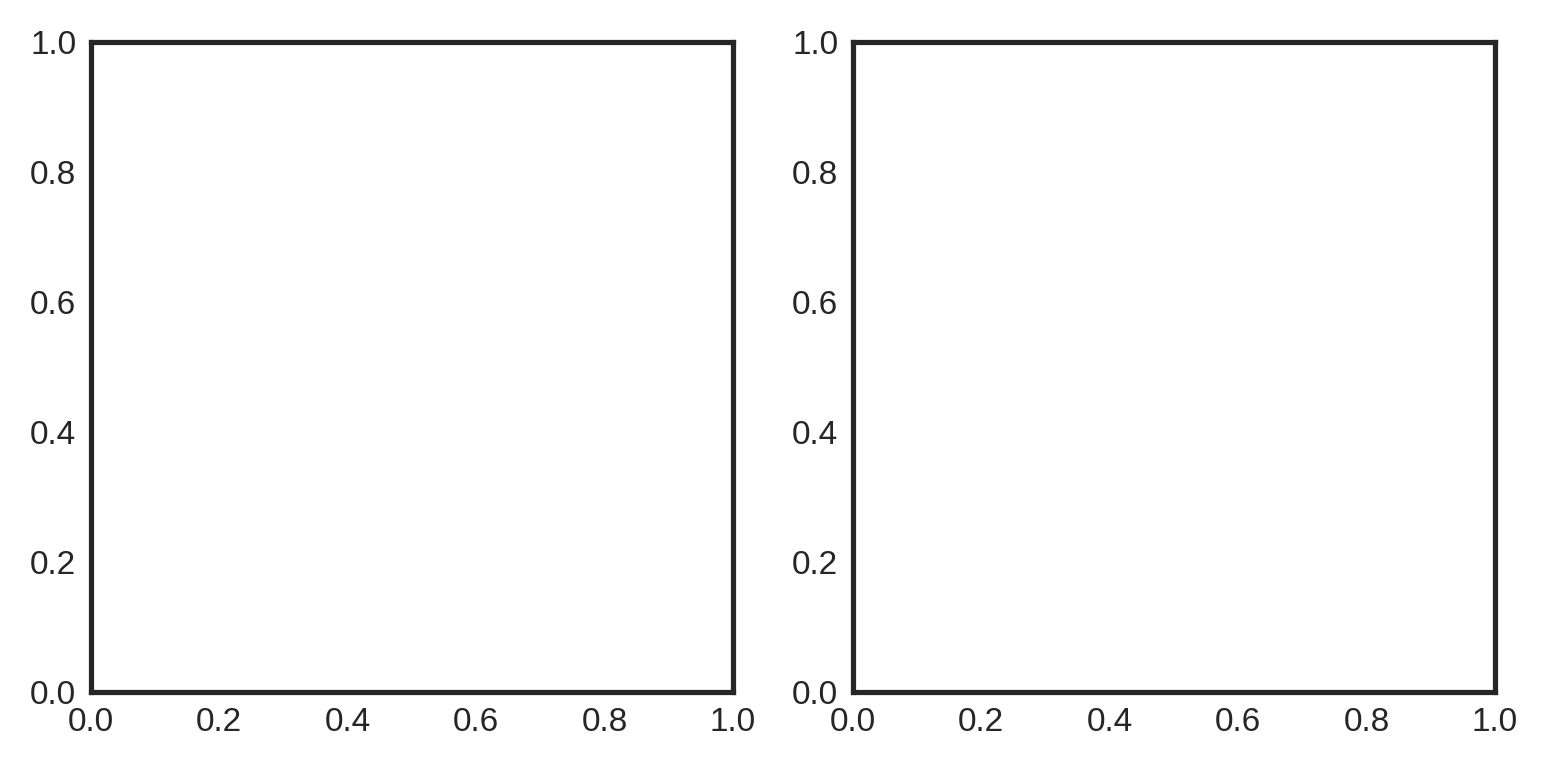

In [117]:
cities_large = roman_cities_wo[roman_cities_wo["pop_est"]>=30000]
cities_medium = roman_cities_wo[(roman_cities_wo["pop_est"] >= 5000) & (roman_cities_wo["pop_est"] < 30000)]
cities_small = roman_cities_wo[roman_cities_wo["pop_est"]<5000]

fig, [ax1, ax2] = plt.subplots(1,2, figsize=[5.2, 2.6], tight_layout=True)

bplot1 = ax1.boxplot([cities_large["ZIw"], cities_medium["ZIw"], cities_small["ZIw"]], whis=[2.5, 97.5], labels=["large", "medium", "small"],
                     patch_artist=True)
#ax1.set_title("A")
ax1.set_ylabel("ZIw")
ax1.tick_params(labelrotation=90)
ax1.set_ylim(0, 2.5)
#ax1.set_ylim(0, 5)

bplot2 = ax2.boxplot([cities_large["DI"], cities_medium["DI"], cities_small["DI"]], whis=[2.5, 97.5], labels=["large", "medium", "small"],
                     patch_artist=True)
#ax1.set_title("A")
ax2.set_ylabel("DI")
ax2.tick_params(labelrotation=90)
ax2.set_ylim(0, 10)

# fill with colors
colors = ["darkred", "darkgreen", "darkblue"]
#for bplot in bplot1:
for bplot in [bplot1, bplot2]:
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

In [ ]:
cities_large = roman_cities_wo[(roman_cities_wo["pop_est"]>=30000) & (roman_cities_wo["Ancient Toponym"]!="Roma")]
cities_large

In [ ]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=[5.2, 2.6], tight_layout=True)

bplot1 = ax1.boxplot([cities_large["ZIw"], cities_medium["ZIw"], cities_small["ZIw"]], whis=[2.5, 97.5], labels=["large", "medium", "small"],
                     patch_artist=True)
#ax1.set_title("A")
ax1.set_ylabel("ZIw")
ax1.tick_params(labelrotation=90)
ax1.set_ylim(0, 2.5)

bplot2 = ax2.boxplot([cities_large["DI"], cities_medium["DI"], cities_small["DI"]], whis=[2.5, 97.5], labels=["large", "medium", "small"],
                     patch_artist=True)
#ax1.set_title("A")
ax2.set_ylabel("DI")
ax2.tick_params(labelrotation=90)
ax2.set_ylim(0, 10)

# fill with colors
colors = ["darkred", "darkgreen", "darkblue"]
#for bplot in bplot1:
for bplot in [bplot1, bplot2]:
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)